# Classification

In the [previous notebook](SimpleClassification.ipynb) we build a simple Linear model to try and classify a simple cire dataset. We discovered that it could not do this well. We will now try to build a more complex model to see if we can improve the performance.

## Getting started

We are going to start by importing our base libraries and setting the random seed for reproducibility. 

In [1]:
from sklearn.datasets import make_circles
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import matplotlib 
import torch.optim as optim


## Data generation

We will use the  ```make_circles``` function from the ```sklearn.datasets``` module to generate our data. This function generates a large circle containing a smaller circle in 2D. A simple toy dataset to visualize clustering and classification algorithms.

In [3]:
# Make 1000 samples 
n_samples = 1000

# Create circles
x, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values



Let's see the dataset 

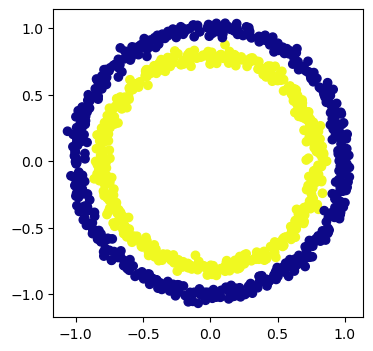

In [4]:
plt.figure(figsize=(4, 4))

plt.scatter(x=x[:, 0], 
            y=x[:, 1], 
            c=y, 
            cmap=plt.cm.plasma);

## Data Preprocessing

We now need to convert our data into tensors and generate our test / train split. We will use the typical 80:20 split for this.

In [5]:
X = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

train_split = int(0.8 * len(X))
X_train = X[:train_split]
X_test = X[train_split:]

y_train = y[:train_split]
y_test = y[train_split:]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


torch.Size([800, 2]) torch.Size([200, 2]) torch.Size([800]) torch.Size([200])


## Building a Model

In the previous example we tried to use a line to fit data that is not linear. We will now try to use a non linear activation function to see if we can fit our data better. 

PyTorch has a number of [non linear activation](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) functions we can use. 

In this example we will use the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) function defined in  [`torch.nn.ReLU()`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)).

In [7]:
def get_device() -> torch.device:
    """
    Returns the appropriate device for the current environment.
    """
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available(): # mac metal backend
        return torch.device('mps')
    else:
        return torch.device('cpu')

# Make device agnostic code
device = get_device()
print(device)


mps


We will still inherit from the nn.Module but change the shape of our model to include a hidden layer with a ReLU activation function.

In [15]:
# Build model with non-linear activation function
class BinaryClassify(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # non-linear activation function

    def forward(self, x):
        # This is a more complex model with 3 layers and a 
        # non-linear activation function between each layer
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


model = BinaryClassify().to(device)
print(model.parameters)
#print(model.state_dict())

<bound method Module.parameters of BinaryClassify(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)>


As you can now see this is a far more complex model than the previous one. If you uncomment the .state_dict() line you can see the weights and biases of the model and there are many more than before.

We will use this model (basically forward is written for us now) this is really easy and for simple tasks ideal. However for more complex models we will need to use the more manual method and define our own forward function.

We can now see what our untrained model does.

## Loss Function and Optimizer

As we are dealing with a binary classification problem we can choose a suitable function from the [PyTorch documentation](https://pytorch.org/docs/stable/nn.html#loss-functions). 

PyTorch has two 
1. [`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) 
2. [`torch.nn.BCEWithLogitsLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)

They are both similar however the BCEWithLogitsLoss is more numerically stable and has a built in sigmoid function.

We will use the Stochastic Gradient Descent (SGD) optimizer to train our model as in the previous lab.

In [16]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = optim.SGD(params=model.parameters(),lr=0.1)


Next we need to see how close our function is to the actual labels we can generate a function to do this this is know as an evaluation function and is basically the opposite of the loss function but it can sometimes be more useful to see how well the model is doing.


In [12]:
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

## Training the Model

We will now train the model using the training data. We will use the same training loop as in the previous lab but using the new data sets, we will now also copy the data to the device to help speed up the training process.

In [21]:
torch.manual_seed(42)

epochs = 1000

# copy to device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model.train()

    # 1. Forward pass
    y_logits = model(X_train).squeeze() 
    # turn logits -> pred probs -> pred labls
    y_pred = torch.round(torch.sigmoid(y_logits)) 
  
    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train) 
    acc = accuracy(y_true=y_train, y_pred=y_pred) 

    # reset the optimizer to zero
    optimizer.zero_grad()
    # calculate the gradients
    loss.backward()
    # update the weights
    optimizer.step()

    # Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy(y_true=y_test, y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.58421, Accuracy: 86.12% | Test loss: 0.58284, Test acc: 85.50%
Epoch: 100 | Loss: 0.50504, Accuracy: 91.00% | Test loss: 0.51253, Test acc: 89.50%
Epoch: 200 | Loss: 0.40016, Accuracy: 96.00% | Test loss: 0.40652, Test acc: 97.00%
Epoch: 300 | Loss: 0.28441, Accuracy: 98.62% | Test loss: 0.28810, Test acc: 99.00%
Epoch: 400 | Loss: 0.19374, Accuracy: 99.50% | Test loss: 0.19195, Test acc: 99.50%
Epoch: 500 | Loss: 0.13542, Accuracy: 99.50% | Test loss: 0.13422, Test acc: 99.50%
Epoch: 600 | Loss: 0.10032, Accuracy: 99.62% | Test loss: 0.10117, Test acc: 99.50%
Epoch: 700 | Loss: 0.07826, Accuracy: 99.62% | Test loss: 0.08068, Test acc: 99.00%
Epoch: 800 | Loss: 0.06392, Accuracy: 99.62% | Test loss: 0.06637, Test acc: 99.00%
Epoch: 900 | Loss: 0.05396, Accuracy: 99.62% | Test loss: 0.05648, Test acc: 99.00%


This is much better accuracy around 80% which is much better than the previous model. Let's make some predictions and see how well the model is doing.

In [22]:
# Make predictions
model.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model(X_test))).squeeze()
y_preds[:10], y[:10] 

(tensor([1., 1., 1., 1., 0., 0., 1., 0., 1., 0.], device='mps:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

We can use the same code we used in the previous lab to plot the decision boundary.

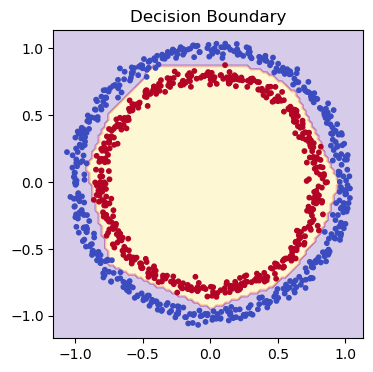

In [23]:
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
plt.figure(figsize=(4, 4))  
grid = np.c_[xx.ravel(), yy.ravel()]
# turn the grid into a tensor
grid_tensor = torch.from_numpy(grid).type(torch.float).to(device)
# make predictions on the grid
model.eval()
with torch.inference_mode():
    test_logits = model(grid_tensor).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    # reshape the predictions back into the meshgrid shape
    zz = test_preds.reshape(xx.shape).detach().cpu().numpy()
    plt.contourf(xx, yy, zz, cmap=plt.cm.plasma, alpha=0.2)
    plt.scatter(x=X[:, 0], y=X[:, 1], c=y, s=10, cmap=plt.cm.coolwarm)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title("Decision Boundary")
    plt.show()



This is much better, you can see for the most part the model has correctly classified the data. With a little more training and a few tweaks we could probably get this to >90% accuracy.